In this sheet I will apply Convolutional Neural Networks for stock prediction of S&P500 index. I will divide data from last 20 years into chunks. Every day contains four values: opening, low, high and closing ones - therefore input data for 30-day chunk has size 30x4. Predicted output has two classes: whether stock will go up or down or stay constant X days after last input.

In [1]:
OBSERVATION_TIME = 200
PREDICTION_AFTER_DAYS = 20
EPOCHS = 500
TEST_SIZE = 0.1
RANDOM_SPLIT = False
NORMALIZED_CHUNKS = True

**IMPORTANT NOTE** Selecting test/valiations chunks randomly from the whole set of observation chunks seems to be a big mistake. It causes situation where network actually seen chunks from the future, therefore the more overfitted network, the better results will be. Network should be trained incrementally - with data from time x to x+1 and validated with data from x+1 to x+2. Then learned with data from x to x+2 and validated with data from x+3 to x+3 and so on..

Parameter RANDOM_SPLIT is responsible for that feature. If True, then data set is split randomly into train/test set (network knows sets from the future). When False, then split is chronological - network works like in real world.

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('./data/AAPL.csv')
df.reindex(index=df.index[::-1])

df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2005-05-18,5.064286,5.365714,4.998571,5.120000,4.432371,159180700
1,2005-05-19,5.111429,5.382857,5.111429,5.364286,4.643848,198290400
2,2005-05-20,5.321429,5.378572,5.312857,5.364286,4.643848,113162700
3,2005-05-23,5.407143,5.700000,5.407143,5.680000,4.917161,260643600
4,2005-05-24,5.635714,5.712857,5.575714,5.671429,4.909742,148365000


In [3]:
# PREPROCESSING

def percentage_to_label(percentage_value):
    return 0 if percentage_value < 0 else 1

def investor_observes_stocks_for(x_days=60, then_buy_stocks=True, and_sells_them=True, after_y_days=10, dataframe=df):
    assert then_buy_stocks
    assert and_sells_them
    observe_buy_sell_process_length = x_days + after_y_days
    
    observed_chunks = []
    observation_results = []
    
    for first_day_of_observation in range(len(dataframe) - observe_buy_sell_process_length):
        buyout_day = first_day_of_observation + x_days
        sell_day = buyout_day + after_y_days
        
        observed_chunk = dataframe[first_day_of_observation:buyout_day].reset_index()
        observation_result = dataframe.iloc[sell_day]
        
        closing_price_on_buyout_day = dataframe.iloc[buyout_day]['Close']
        opening_price_on_sell_day = dataframe.iloc[sell_day]['Open']
        
        relative_price_change_as_percentage = (opening_price_on_sell_day - closing_price_on_buyout_day) / closing_price_on_buyout_day * 100
        
        observed_chunks += [observed_chunk]
        observation_results += [percentage_to_label(relative_price_change_as_percentage)]
    
    return observed_chunks, observation_results

observed_chunks, observation_results = investor_observes_stocks_for(x_days=OBSERVATION_TIME, then_buy_stocks=True, and_sells_them=True, after_y_days=PREDICTION_AFTER_DAYS)

In [4]:
observed_chunks[0]

,index,Date,Open,High,Low,Close,Adj Close,Volume
0,0,2005-05-18,5.064286,5.365714,4.998571,5.120000,4.432371,159180700
1,1,2005-05-19,5.111429,5.382857,5.111429,5.364286,4.643848,198290400
2,2,2005-05-20,5.321429,5.378572,5.312857,5.364286,4.643848,113162700
3,3,2005-05-23,5.407143,5.700000,5.407143,5.680000,4.917161,260643600
4,4,2005-05-24,5.635714,5.712857,5.575714,5.671429,4.909742,148365000
...,...,...,...,...,...,...,...,...
195,195,2006-02-27,10.284286,10.302857,10.092857,10.141429,8.779409,197810200
196,196,2006-02-28,10.225715,10.342857,9.728572,9.784286,8.470230,316745100
197,197,2006-03-01,9.834286,9.927143,9.717143,9.871428,8.545672,190954400
198,198,2006-03-02,9.855714,9.998571,9.810000,9.944285,8.608742,156318400


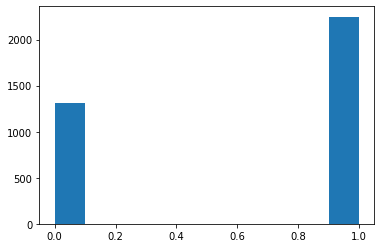

1    2248
0    1307
dtype: int64

In [5]:
import matplotlib.pyplot as plt

plt.hist(observation_results)
plt.show()

pd.Series(observation_results).value_counts()

In [6]:
# NORMALIZATION

def normalize_chunk(chunk):
    df = chunk.copy()
    for label_to_normalize in ['Open', 'High', 'Low', 'Close', 'Adj Close']:
        np_arr = df[label_to_normalize].to_numpy()
        df[label_to_normalize] = pd.Series((np.array(np_arr) - np.mean(np_arr)) / np.std(np_arr))
    return df

def normalize_chunks(chunks):
    return list(map(lambda x: normalize_chunk(x), chunks))

observed_chunks = normalize_chunks(observed_chunks) if NORMALIZED_CHUNKS else observed_chunks

In [7]:
# TRAIN TEST SPLIT

from sklearn.model_selection import train_test_split

X = np.array(list(map(lambda df: df[['Open', 'High', 'Low', 'Close', 'Adj Close']].to_numpy(), observed_chunks)))
Y = np.array(observation_results).astype('float32')

def chronological_split(X_data, Y_data, test_size=0.25):
    training_test_split_index = int((1 - test_size) * len(X_data))
    X_train = X_data[:training_test_split_index]
    Y_train = Y_data[:training_test_split_index]
    X_test = X_data[training_test_split_index:]
    Y_test = Y_data[training_test_split_index:]
    return X_train, X_test, Y_train, Y_test
    
def random_split(X_data, Y_data, test_size=0.25):
    return train_test_split(X_data, Y_data, test_size=test_size, random_state=42)

X_train, X_test, Y_train, Y_test = random_split(X, Y, TEST_SIZE) if RANDOM_SPLIT else chronological_split(X, Y, TEST_SIZE)

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((3199, 200, 5), (3199,), (356, 200, 5), (356,))

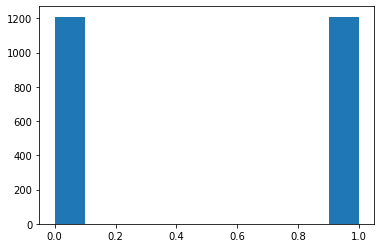

0.0    1209
1.0    1209
dtype: int64

In [8]:
# UNDERSAMPLING TRAINING SET

import random

def undersample_and_shuffle(X, Y):
    count_class_1, count_class_0 = pd.Series(Y).value_counts()

    lower_count = count_class_0 if count_class_0 < count_class_1 else count_class_1
    lower_class = 0 if count_class_0 < count_class_1 else 1
    
    diff = abs(count_class_0 - count_class_1)
    
    vec0 = random.sample([(x, y) for x, y in zip(X, Y) if y == 0], lower_count)
    vec1 = random.sample([(x, y) for x, y in zip(X, Y) if y == 1], lower_count)

    
    vec = vec0 + vec1
    random.shuffle(vec)
    return np.array(list(map(lambda x: x[0], vec))), np.array(list(map(lambda x: x[1], vec)))
    
X_train_balanced, Y_train_balanced = undersample_and_shuffle(X_train, Y_train)

plt.hist(Y_train_balanced)
plt.show()

pd.Series(Y_train_balanced).value_counts()

In [9]:
from keras import models
from keras.models import Sequential
from keras.layers import Convolution1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.layers.core import Dense, Dropout, Activation, Flatten

model = Sequential()
model.add(Convolution1D(input_shape = (OBSERVATION_TIME, 5), filters=16, kernel_size=5, padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Convolution1D(filters=8, kernel_size=5, padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(64))
model.add(BatchNormalization())
model.add(LeakyReLU())

model.add(Dense(1, activation='sigmoid'))

model.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 200, 16)           416       
_________________________________________________________________
batch_normalization_1 (Batch (None, 200, 16)           64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 200, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 200, 8)            648       
_________________________________________________________________
batch_normalization_2 (Batch (None, 200, 8)            32        
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 200, 8)           

In [10]:
from keras.optimizers import Nadam
import keras

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]


model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=METRICS)

In [11]:

history = model.fit(x=X_train_balanced, 
                    y=Y_train_balanced, 
                    batch_size=128, 
                    epochs=EPOCHS, 
                    validation_data=(X_test, Y_test),
                    shuffle=True)

model.save("model-binary.h5")
model.save_weights('model-binry-weights.h5')

Train on 2418 samples, validate on 356 samples
Epoch 1/500
2418/2418 [==============================] - 1s 428us/step - loss: 0.7938 - tp: 680.0000 - fp: 639.0000 - tn: 570.0000 - fn: 529.0000 - accuracy: 0.5170 - precision: 0.5155 - recall: 0.5624 - auc: 0.5230 - val_loss: 0.7886 - val_tp: 171.0000 - val_fp: 57.0000 - val_tn: 41.0000 - val_fn: 87.0000 - val_accuracy: 0.5955 - val_precision: 0.7500 - val_recall: 0.6628 - val_auc: 0.5683
Epoch 2/500
2418/2418 [==============================] - 0s 158us/step - loss: 0.7471 - tp: 701.0000 - fp: 589.0000 - tn: 620.0000 - fn: 508.0000 - accuracy: 0.5463 - precision: 0.5434 - recall: 0.5798 - auc: 0.5583 - val_loss: 0.7823 - val_tp: 111.0000 - val_fp: 31.0000 - val_tn: 67.0000 - val_fn: 147.0000 - val_accuracy: 0.5000 - val_precision: 0.7817 - val_recall: 0.4302 - val_auc: 0.5893
Epoch 3/500
2418/2418 [==============================] - 0s 159us/step - loss: 0.7174 - tp: 694.0000 - fp: 540.0000 - tn: 669.0000 - fn: 515.0000 - accuracy: 0.5637

Epoch 22/500
2418/2418 [==============================] - 0s 161us/step - loss: 0.5499 - tp: 867.0000 - fp: 322.0000 - tn: 887.0000 - fn: 342.0000 - accuracy: 0.7254 - precision: 0.7292 - recall: 0.7171 - auc: 0.7943 - val_loss: 0.7966 - val_tp: 106.0000 - val_fp: 11.0000 - val_tn: 87.0000 - val_fn: 152.0000 - val_accuracy: 0.5421 - val_precision: 0.9060 - val_recall: 0.4109 - val_auc: 0.6744
Epoch 23/500
2418/2418 [==============================] - 0s 157us/step - loss: 0.5504 - tp: 865.0000 - fp: 343.0000 - tn: 866.0000 - fn: 344.0000 - accuracy: 0.7159 - precision: 0.7161 - recall: 0.7155 - auc: 0.7924 - val_loss: 0.7898 - val_tp: 91.0000 - val_fp: 7.0000 - val_tn: 91.0000 - val_fn: 167.0000 - val_accuracy: 0.5112 - val_precision: 0.9286 - val_recall: 0.3527 - val_auc: 0.6707
Epoch 24/500
2418/2418 [==============================] - 0s 169us/step - loss: 0.5425 - tp: 865.0000 - fp: 321.0000 - tn: 888.0000 - fn: 344.0000 - accuracy: 0.7250 - precision: 0.7293 - recall: 0.7155 - auc: 

Epoch 43/500
2418/2418 [==============================] - 0s 142us/step - loss: 0.4394 - tp: 982.0000 - fp: 214.0000 - tn: 995.0000 - fn: 227.0000 - accuracy: 0.8176 - precision: 0.8211 - recall: 0.8122 - auc: 0.8855 - val_loss: 0.7445 - val_tp: 114.0000 - val_fp: 14.0000 - val_tn: 84.0000 - val_fn: 144.0000 - val_accuracy: 0.5562 - val_precision: 0.8906 - val_recall: 0.4419 - val_auc: 0.7509
Epoch 44/500
2418/2418 [==============================] - 0s 142us/step - loss: 0.4418 - tp: 958.0000 - fp: 239.0000 - tn: 970.0000 - fn: 251.0000 - accuracy: 0.7974 - precision: 0.8003 - recall: 0.7924 - auc: 0.8832 - val_loss: 0.8162 - val_tp: 93.0000 - val_fp: 12.0000 - val_tn: 86.0000 - val_fn: 165.0000 - val_accuracy: 0.5028 - val_precision: 0.8857 - val_recall: 0.3605 - val_auc: 0.7156
Epoch 45/500
2418/2418 [==============================] - 0s 152us/step - loss: 0.4219 - tp: 960.0000 - fp: 221.0000 - tn: 988.0000 - fn: 249.0000 - accuracy: 0.8056 - precision: 0.8129 - recall: 0.7940 - auc:

Epoch 64/500
2418/2418 [==============================] - 0s 137us/step - loss: 0.3510 - tp: 1033.0000 - fp: 180.0000 - tn: 1029.0000 - fn: 176.0000 - accuracy: 0.8528 - precision: 0.8516 - recall: 0.8544 - auc: 0.9317 - val_loss: 0.7211 - val_tp: 115.0000 - val_fp: 18.0000 - val_tn: 80.0000 - val_fn: 143.0000 - val_accuracy: 0.5478 - val_precision: 0.8647 - val_recall: 0.4457 - val_auc: 0.7036
Epoch 65/500
2418/2418 [==============================] - 0s 140us/step - loss: 0.3517 - tp: 1034.0000 - fp: 177.0000 - tn: 1032.0000 - fn: 175.0000 - accuracy: 0.8544 - precision: 0.8538 - recall: 0.8553 - auc: 0.9313 - val_loss: 0.7589 - val_tp: 122.0000 - val_fp: 20.0000 - val_tn: 78.0000 - val_fn: 136.0000 - val_accuracy: 0.5618 - val_precision: 0.8592 - val_recall: 0.4729 - val_auc: 0.6758
Epoch 66/500
2418/2418 [==============================] - 0s 142us/step - loss: 0.3480 - tp: 1034.0000 - fp: 167.0000 - tn: 1042.0000 - fn: 175.0000 - accuracy: 0.8586 - precision: 0.8609 - recall: 0.8553

Epoch 85/500
2418/2418 [==============================] - 0s 140us/step - loss: 0.3010 - tp: 1065.0000 - fp: 159.0000 - tn: 1050.0000 - fn: 144.0000 - accuracy: 0.8747 - precision: 0.8701 - recall: 0.8809 - auc: 0.9496 - val_loss: 0.7746 - val_tp: 117.0000 - val_fp: 24.0000 - val_tn: 74.0000 - val_fn: 141.0000 - val_accuracy: 0.5365 - val_precision: 0.8298 - val_recall: 0.4535 - val_auc: 0.7044
Epoch 86/500
2418/2418 [==============================] - 0s 140us/step - loss: 0.2849 - tp: 1079.0000 - fp: 139.0000 - tn: 1070.0000 - fn: 130.0000 - accuracy: 0.8888 - precision: 0.8859 - recall: 0.8925 - auc: 0.9574 - val_loss: 0.7852 - val_tp: 139.0000 - val_fp: 29.0000 - val_tn: 69.0000 - val_fn: 119.0000 - val_accuracy: 0.5843 - val_precision: 0.8274 - val_recall: 0.5388 - val_auc: 0.6743
Epoch 87/500
2418/2418 [==============================] - 0s 137us/step - loss: 0.2972 - tp: 1056.0000 - fp: 148.0000 - tn: 1061.0000 - fn: 153.0000 - accuracy: 0.8755 - precision: 0.8771 - recall: 0.8734

Epoch 106/500
2418/2418 [==============================] - 0s 142us/step - loss: 0.2646 - tp: 1092.0000 - fp: 128.0000 - tn: 1081.0000 - fn: 117.0000 - accuracy: 0.8987 - precision: 0.8951 - recall: 0.9032 - auc: 0.9607 - val_loss: 0.8711 - val_tp: 99.0000 - val_fp: 11.0000 - val_tn: 87.0000 - val_fn: 159.0000 - val_accuracy: 0.5225 - val_precision: 0.9000 - val_recall: 0.3837 - val_auc: 0.7700
Epoch 107/500
2418/2418 [==============================] - 0s 149us/step - loss: 0.2548 - tp: 1077.0000 - fp: 96.0000 - tn: 1113.0000 - fn: 132.0000 - accuracy: 0.9057 - precision: 0.9182 - recall: 0.8908 - auc: 0.9647 - val_loss: 0.8621 - val_tp: 150.0000 - val_fp: 37.0000 - val_tn: 61.0000 - val_fn: 108.0000 - val_accuracy: 0.5927 - val_precision: 0.8021 - val_recall: 0.5814 - val_auc: 0.6507
Epoch 108/500
2418/2418 [==============================] - 0s 147us/step - loss: 0.2601 - tp: 1091.0000 - fp: 130.0000 - tn: 1079.0000 - fn: 118.0000 - accuracy: 0.8974 - precision: 0.8935 - recall: 0.902

Epoch 127/500
2418/2418 [==============================] - 0s 143us/step - loss: 0.2281 - tp: 1102.0000 - fp: 107.0000 - tn: 1102.0000 - fn: 107.0000 - accuracy: 0.9115 - precision: 0.9115 - recall: 0.9115 - auc: 0.9713 - val_loss: 0.7985 - val_tp: 106.0000 - val_fp: 22.0000 - val_tn: 76.0000 - val_fn: 152.0000 - val_accuracy: 0.5112 - val_precision: 0.8281 - val_recall: 0.4109 - val_auc: 0.6919
Epoch 128/500
2418/2418 [==============================] - 0s 143us/step - loss: 0.2312 - tp: 1101.0000 - fp: 121.0000 - tn: 1088.0000 - fn: 108.0000 - accuracy: 0.9053 - precision: 0.9010 - recall: 0.9107 - auc: 0.9703 - val_loss: 0.9005 - val_tp: 108.0000 - val_fp: 24.0000 - val_tn: 74.0000 - val_fn: 150.0000 - val_accuracy: 0.5112 - val_precision: 0.8182 - val_recall: 0.4186 - val_auc: 0.6679
Epoch 129/500
2418/2418 [==============================] - 0s 147us/step - loss: 0.2195 - tp: 1101.0000 - fp: 94.0000 - tn: 1115.0000 - fn: 108.0000 - accuracy: 0.9165 - precision: 0.9213 - recall: 0.91

Epoch 148/500
2418/2418 [==============================] - 0s 150us/step - loss: 0.2111 - tp: 1102.0000 - fp: 94.0000 - tn: 1115.0000 - fn: 107.0000 - accuracy: 0.9169 - precision: 0.9214 - recall: 0.9115 - auc: 0.9749 - val_loss: 0.8194 - val_tp: 131.0000 - val_fp: 20.0000 - val_tn: 78.0000 - val_fn: 127.0000 - val_accuracy: 0.5871 - val_precision: 0.8675 - val_recall: 0.5078 - val_auc: 0.6936
Epoch 149/500
2418/2418 [==============================] - 28s 12ms/step - loss: 0.2034 - tp: 1115.0000 - fp: 109.0000 - tn: 1100.0000 - fn: 94.0000 - accuracy: 0.9160 - precision: 0.9109 - recall: 0.9222 - auc: 0.9775 - val_loss: 0.7815 - val_tp: 117.0000 - val_fp: 15.0000 - val_tn: 83.0000 - val_fn: 141.0000 - val_accuracy: 0.5618 - val_precision: 0.8864 - val_recall: 0.4535 - val_auc: 0.7536
Epoch 150/500
2418/2418 [==============================] - 0s 154us/step - loss: 0.2068 - tp: 1103.0000 - fp: 90.0000 - tn: 1119.0000 - fn: 106.0000 - accuracy: 0.9189 - precision: 0.9246 - recall: 0.9123

Epoch 169/500
2418/2418 [==============================] - 0s 157us/step - loss: 0.1802 - tp: 1132.0000 - fp: 86.0000 - tn: 1123.0000 - fn: 77.0000 - accuracy: 0.9326 - precision: 0.9294 - recall: 0.9363 - auc: 0.9825 - val_loss: 0.9247 - val_tp: 120.0000 - val_fp: 14.0000 - val_tn: 84.0000 - val_fn: 138.0000 - val_accuracy: 0.5730 - val_precision: 0.8955 - val_recall: 0.4651 - val_auc: 0.7446
Epoch 170/500
2418/2418 [==============================] - 0s 163us/step - loss: 0.1834 - tp: 1114.0000 - fp: 83.0000 - tn: 1126.0000 - fn: 95.0000 - accuracy: 0.9264 - precision: 0.9307 - recall: 0.9214 - auc: 0.9817 - val_loss: 0.8343 - val_tp: 144.0000 - val_fp: 31.0000 - val_tn: 67.0000 - val_fn: 114.0000 - val_accuracy: 0.5927 - val_precision: 0.8229 - val_recall: 0.5581 - val_auc: 0.6894
Epoch 171/500
2418/2418 [==============================] - 0s 151us/step - loss: 0.1755 - tp: 1131.0000 - fp: 82.0000 - tn: 1127.0000 - fn: 78.0000 - accuracy: 0.9338 - precision: 0.9324 - recall: 0.9355 - 

Epoch 190/500
2418/2418 [==============================] - 0s 150us/step - loss: 0.1619 - tp: 1131.0000 - fp: 66.0000 - tn: 1143.0000 - fn: 78.0000 - accuracy: 0.9404 - precision: 0.9449 - recall: 0.9355 - auc: 0.9855 - val_loss: 0.8477 - val_tp: 106.0000 - val_fp: 12.0000 - val_tn: 86.0000 - val_fn: 152.0000 - val_accuracy: 0.5393 - val_precision: 0.8983 - val_recall: 0.4109 - val_auc: 0.7388
Epoch 191/500
2418/2418 [==============================] - 0s 151us/step - loss: 0.1705 - tp: 1129.0000 - fp: 81.0000 - tn: 1128.0000 - fn: 80.0000 - accuracy: 0.9334 - precision: 0.9331 - recall: 0.9338 - auc: 0.9834 - val_loss: 0.8783 - val_tp: 164.0000 - val_fp: 33.0000 - val_tn: 65.0000 - val_fn: 94.0000 - val_accuracy: 0.6433 - val_precision: 0.8325 - val_recall: 0.6357 - val_auc: 0.6884
Epoch 192/500
2418/2418 [==============================] - 0s 149us/step - loss: 0.1791 - tp: 1134.0000 - fp: 82.0000 - tn: 1127.0000 - fn: 75.0000 - accuracy: 0.9351 - precision: 0.9326 - recall: 0.9380 - a

Epoch 211/500
2418/2418 [==============================] - 0s 159us/step - loss: 0.1546 - tp: 1138.0000 - fp: 65.0000 - tn: 1144.0000 - fn: 71.0000 - accuracy: 0.9438 - precision: 0.9460 - recall: 0.9413 - auc: 0.9867 - val_loss: 0.9548 - val_tp: 130.0000 - val_fp: 23.0000 - val_tn: 75.0000 - val_fn: 128.0000 - val_accuracy: 0.5758 - val_precision: 0.8497 - val_recall: 0.5039 - val_auc: 0.7070
Epoch 212/500
2418/2418 [==============================] - 0s 160us/step - loss: 0.1614 - tp: 1128.0000 - fp: 80.0000 - tn: 1129.0000 - fn: 81.0000 - accuracy: 0.9334 - precision: 0.9338 - recall: 0.9330 - auc: 0.9855 - val_loss: 0.7925 - val_tp: 135.0000 - val_fp: 19.0000 - val_tn: 79.0000 - val_fn: 123.0000 - val_accuracy: 0.6011 - val_precision: 0.8766 - val_recall: 0.5233 - val_auc: 0.7379
Epoch 213/500
2418/2418 [==============================] - 0s 176us/step - loss: 0.1604 - tp: 1141.0000 - fp: 70.0000 - tn: 1139.0000 - fn: 68.0000 - accuracy: 0.9429 - precision: 0.9422 - recall: 0.9438 - 

Epoch 232/500
2418/2418 [==============================] - 0s 164us/step - loss: 0.1335 - tp: 1156.0000 - fp: 58.0000 - tn: 1151.0000 - fn: 53.0000 - accuracy: 0.9541 - precision: 0.9522 - recall: 0.9562 - auc: 0.9903 - val_loss: 0.9044 - val_tp: 113.0000 - val_fp: 12.0000 - val_tn: 86.0000 - val_fn: 145.0000 - val_accuracy: 0.5590 - val_precision: 0.9040 - val_recall: 0.4380 - val_auc: 0.7318
Epoch 233/500
2418/2418 [==============================] - 0s 161us/step - loss: 0.1274 - tp: 1152.0000 - fp: 54.0000 - tn: 1155.0000 - fn: 57.0000 - accuracy: 0.9541 - precision: 0.9552 - recall: 0.9529 - auc: 0.9917 - val_loss: 1.1177 - val_tp: 117.0000 - val_fp: 22.0000 - val_tn: 76.0000 - val_fn: 141.0000 - val_accuracy: 0.5421 - val_precision: 0.8417 - val_recall: 0.4535 - val_auc: 0.6742
Epoch 234/500
2418/2418 [==============================] - 0s 159us/step - loss: 0.1533 - tp: 1144.0000 - fp: 81.0000 - tn: 1128.0000 - fn: 65.0000 - accuracy: 0.9396 - precision: 0.9339 - recall: 0.9462 - 

Epoch 253/500
2418/2418 [==============================] - 0s 167us/step - loss: 0.1146 - tp: 1160.0000 - fp: 44.0000 - tn: 1165.0000 - fn: 49.0000 - accuracy: 0.9615 - precision: 0.9635 - recall: 0.9595 - auc: 0.9937 - val_loss: 0.9041 - val_tp: 114.0000 - val_fp: 14.0000 - val_tn: 84.0000 - val_fn: 144.0000 - val_accuracy: 0.5562 - val_precision: 0.8906 - val_recall: 0.4419 - val_auc: 0.7367
Epoch 254/500
2418/2418 [==============================] - 0s 162us/step - loss: 0.1256 - tp: 1156.0000 - fp: 55.0000 - tn: 1154.0000 - fn: 53.0000 - accuracy: 0.9553 - precision: 0.9546 - recall: 0.9562 - auc: 0.9915 - val_loss: 0.7761 - val_tp: 143.0000 - val_fp: 12.0000 - val_tn: 86.0000 - val_fn: 115.0000 - val_accuracy: 0.6433 - val_precision: 0.9226 - val_recall: 0.5543 - val_auc: 0.7796
Epoch 255/500
2418/2418 [==============================] - 0s 164us/step - loss: 0.1334 - tp: 1150.0000 - fp: 60.0000 - tn: 1149.0000 - fn: 59.0000 - accuracy: 0.9508 - precision: 0.9504 - recall: 0.9512 - 

Epoch 274/500
2418/2418 [==============================] - 0s 159us/step - loss: 0.1178 - tp: 1154.0000 - fp: 45.0000 - tn: 1164.0000 - fn: 55.0000 - accuracy: 0.9586 - precision: 0.9625 - recall: 0.9545 - auc: 0.9928 - val_loss: 0.7629 - val_tp: 143.0000 - val_fp: 21.0000 - val_tn: 77.0000 - val_fn: 115.0000 - val_accuracy: 0.6180 - val_precision: 0.8720 - val_recall: 0.5543 - val_auc: 0.7552
Epoch 275/500
2418/2418 [==============================] - 0s 157us/step - loss: 0.1273 - tp: 1154.0000 - fp: 57.0000 - tn: 1152.0000 - fn: 55.0000 - accuracy: 0.9537 - precision: 0.9529 - recall: 0.9545 - auc: 0.9911 - val_loss: 1.0303 - val_tp: 110.0000 - val_fp: 19.0000 - val_tn: 79.0000 - val_fn: 148.0000 - val_accuracy: 0.5309 - val_precision: 0.8527 - val_recall: 0.4264 - val_auc: 0.7108
Epoch 276/500
2418/2418 [==============================] - 0s 157us/step - loss: 0.1072 - tp: 1162.0000 - fp: 45.0000 - tn: 1164.0000 - fn: 47.0000 - accuracy: 0.9620 - precision: 0.9627 - recall: 0.9611 - 

Epoch 295/500
2418/2418 [==============================] - 0s 154us/step - loss: 0.0989 - tp: 1177.0000 - fp: 46.0000 - tn: 1163.0000 - fn: 32.0000 - accuracy: 0.9677 - precision: 0.9624 - recall: 0.9735 - auc: 0.9954 - val_loss: 1.2405 - val_tp: 133.0000 - val_fp: 22.0000 - val_tn: 76.0000 - val_fn: 125.0000 - val_accuracy: 0.5871 - val_precision: 0.8581 - val_recall: 0.5155 - val_auc: 0.6571
Epoch 296/500
2418/2418 [==============================] - 0s 180us/step - loss: 0.1015 - tp: 1162.0000 - fp: 40.0000 - tn: 1169.0000 - fn: 47.0000 - accuracy: 0.9640 - precision: 0.9667 - recall: 0.9611 - auc: 0.9951 - val_loss: 1.1927 - val_tp: 144.0000 - val_fp: 23.0000 - val_tn: 75.0000 - val_fn: 114.0000 - val_accuracy: 0.6152 - val_precision: 0.8623 - val_recall: 0.5581 - val_auc: 0.6625
Epoch 297/500
2418/2418 [==============================] - 0s 182us/step - loss: 0.1115 - tp: 1155.0000 - fp: 43.0000 - tn: 1166.0000 - fn: 54.0000 - accuracy: 0.9599 - precision: 0.9641 - recall: 0.9553 - 

Epoch 316/500
2418/2418 [==============================] - 0s 168us/step - loss: 0.0979 - tp: 1171.0000 - fp: 39.0000 - tn: 1170.0000 - fn: 38.0000 - accuracy: 0.9682 - precision: 0.9678 - recall: 0.9686 - auc: 0.9949 - val_loss: 1.4736 - val_tp: 147.0000 - val_fp: 23.0000 - val_tn: 75.0000 - val_fn: 111.0000 - val_accuracy: 0.6236 - val_precision: 0.8647 - val_recall: 0.5698 - val_auc: 0.6491
Epoch 317/500
2418/2418 [==============================] - 0s 169us/step - loss: 0.1048 - tp: 1156.0000 - fp: 41.0000 - tn: 1168.0000 - fn: 53.0000 - accuracy: 0.9611 - precision: 0.9657 - recall: 0.9562 - auc: 0.9939 - val_loss: 1.0186 - val_tp: 132.0000 - val_fp: 20.0000 - val_tn: 78.0000 - val_fn: 126.0000 - val_accuracy: 0.5899 - val_precision: 0.8684 - val_recall: 0.5116 - val_auc: 0.7157
Epoch 318/500
2418/2418 [==============================] - 0s 185us/step - loss: 0.1040 - tp: 1167.0000 - fp: 39.0000 - tn: 1170.0000 - fn: 42.0000 - accuracy: 0.9665 - precision: 0.9677 - recall: 0.9653 - 

Epoch 337/500
2418/2418 [==============================] - 0s 143us/step - loss: 0.0940 - tp: 1168.0000 - fp: 32.0000 - tn: 1177.0000 - fn: 41.0000 - accuracy: 0.9698 - precision: 0.9733 - recall: 0.9661 - auc: 0.9947 - val_loss: 0.8294 - val_tp: 141.0000 - val_fp: 21.0000 - val_tn: 77.0000 - val_fn: 117.0000 - val_accuracy: 0.6124 - val_precision: 0.8704 - val_recall: 0.5465 - val_auc: 0.7437
Epoch 338/500
2418/2418 [==============================] - 0s 142us/step - loss: 0.0920 - tp: 1171.0000 - fp: 42.0000 - tn: 1167.0000 - fn: 38.0000 - accuracy: 0.9669 - precision: 0.9654 - recall: 0.9686 - auc: 0.9957 - val_loss: 0.9417 - val_tp: 144.0000 - val_fp: 19.0000 - val_tn: 79.0000 - val_fn: 114.0000 - val_accuracy: 0.6264 - val_precision: 0.8834 - val_recall: 0.5581 - val_auc: 0.7320
Epoch 339/500
2418/2418 [==============================] - 0s 144us/step - loss: 0.0908 - tp: 1169.0000 - fp: 36.0000 - tn: 1173.0000 - fn: 40.0000 - accuracy: 0.9686 - precision: 0.9701 - recall: 0.9669 - 

Epoch 358/500
2418/2418 [==============================] - 0s 171us/step - loss: 0.0876 - tp: 1172.0000 - fp: 33.0000 - tn: 1176.0000 - fn: 37.0000 - accuracy: 0.9711 - precision: 0.9726 - recall: 0.9694 - auc: 0.9960 - val_loss: 0.9718 - val_tp: 141.0000 - val_fp: 40.0000 - val_tn: 58.0000 - val_fn: 117.0000 - val_accuracy: 0.5590 - val_precision: 0.7790 - val_recall: 0.5465 - val_auc: 0.6385
Epoch 359/500
2418/2418 [==============================] - 0s 156us/step - loss: 0.0891 - tp: 1169.0000 - fp: 45.0000 - tn: 1164.0000 - fn: 40.0000 - accuracy: 0.9648 - precision: 0.9629 - recall: 0.9669 - auc: 0.9957 - val_loss: 0.7904 - val_tp: 157.0000 - val_fp: 26.0000 - val_tn: 72.0000 - val_fn: 101.0000 - val_accuracy: 0.6433 - val_precision: 0.8579 - val_recall: 0.6085 - val_auc: 0.7287
Epoch 360/500
2418/2418 [==============================] - 0s 157us/step - loss: 0.0921 - tp: 1174.0000 - fp: 43.0000 - tn: 1166.0000 - fn: 35.0000 - accuracy: 0.9677 - precision: 0.9647 - recall: 0.9711 - 

Epoch 379/500
2418/2418 [==============================] - 0s 149us/step - loss: 0.0832 - tp: 1173.0000 - fp: 33.0000 - tn: 1176.0000 - fn: 36.0000 - accuracy: 0.9715 - precision: 0.9726 - recall: 0.9702 - auc: 0.9965 - val_loss: 1.1625 - val_tp: 140.0000 - val_fp: 18.0000 - val_tn: 80.0000 - val_fn: 118.0000 - val_accuracy: 0.6180 - val_precision: 0.8861 - val_recall: 0.5426 - val_auc: 0.6842
Epoch 380/500
2418/2418 [==============================] - 0s 147us/step - loss: 0.0881 - tp: 1169.0000 - fp: 36.0000 - tn: 1173.0000 - fn: 40.0000 - accuracy: 0.9686 - precision: 0.9701 - recall: 0.9669 - auc: 0.9953 - val_loss: 0.8596 - val_tp: 134.0000 - val_fp: 23.0000 - val_tn: 75.0000 - val_fn: 124.0000 - val_accuracy: 0.5871 - val_precision: 0.8535 - val_recall: 0.5194 - val_auc: 0.7283
Epoch 381/500
2418/2418 [==============================] - 0s 146us/step - loss: 0.0872 - tp: 1161.0000 - fp: 34.0000 - tn: 1175.0000 - fn: 48.0000 - accuracy: 0.9661 - precision: 0.9715 - recall: 0.9603 - 

Epoch 400/500
2418/2418 [==============================] - 0s 142us/step - loss: 0.0953 - tp: 1168.0000 - fp: 45.0000 - tn: 1164.0000 - fn: 41.0000 - accuracy: 0.9644 - precision: 0.9629 - recall: 0.9661 - auc: 0.9943 - val_loss: 1.0552 - val_tp: 138.0000 - val_fp: 23.0000 - val_tn: 75.0000 - val_fn: 120.0000 - val_accuracy: 0.5983 - val_precision: 0.8571 - val_recall: 0.5349 - val_auc: 0.7038
Epoch 401/500
2418/2418 [==============================] - 0s 142us/step - loss: 0.0832 - tp: 1167.0000 - fp: 31.0000 - tn: 1178.0000 - fn: 42.0000 - accuracy: 0.9698 - precision: 0.9741 - recall: 0.9653 - auc: 0.9961 - val_loss: 1.1685 - val_tp: 142.0000 - val_fp: 27.0000 - val_tn: 71.0000 - val_fn: 116.0000 - val_accuracy: 0.5983 - val_precision: 0.8402 - val_recall: 0.5504 - val_auc: 0.6649
Epoch 402/500
2418/2418 [==============================] - 0s 143us/step - loss: 0.0798 - tp: 1172.0000 - fp: 30.0000 - tn: 1179.0000 - fn: 37.0000 - accuracy: 0.9723 - precision: 0.9750 - recall: 0.9694 - 

Epoch 421/500
2418/2418 [==============================] - 0s 157us/step - loss: 0.0677 - tp: 1178.0000 - fp: 25.0000 - tn: 1184.0000 - fn: 31.0000 - accuracy: 0.9768 - precision: 0.9792 - recall: 0.9744 - auc: 0.9977 - val_loss: 1.3453 - val_tp: 152.0000 - val_fp: 36.0000 - val_tn: 62.0000 - val_fn: 106.0000 - val_accuracy: 0.6011 - val_precision: 0.8085 - val_recall: 0.5891 - val_auc: 0.6164
Epoch 422/500
2418/2418 [==============================] - 0s 170us/step - loss: 0.0679 - tp: 1177.0000 - fp: 17.0000 - tn: 1192.0000 - fn: 32.0000 - accuracy: 0.9797 - precision: 0.9858 - recall: 0.9735 - auc: 0.9976 - val_loss: 1.6970 - val_tp: 123.0000 - val_fp: 26.0000 - val_tn: 72.0000 - val_fn: 135.0000 - val_accuracy: 0.5478 - val_precision: 0.8255 - val_recall: 0.4767 - val_auc: 0.6213
Epoch 423/500
2418/2418 [==============================] - 0s 167us/step - loss: 0.0675 - tp: 1184.0000 - fp: 32.0000 - tn: 1177.0000 - fn: 25.0000 - accuracy: 0.9764 - precision: 0.9737 - recall: 0.9793 - 

Epoch 442/500
2418/2418 [==============================] - 0s 146us/step - loss: 0.0735 - tp: 1179.0000 - fp: 32.0000 - tn: 1177.0000 - fn: 30.0000 - accuracy: 0.9744 - precision: 0.9736 - recall: 0.9752 - auc: 0.9971 - val_loss: 1.5624 - val_tp: 135.0000 - val_fp: 36.0000 - val_tn: 62.0000 - val_fn: 123.0000 - val_accuracy: 0.5534 - val_precision: 0.7895 - val_recall: 0.5233 - val_auc: 0.6106
Epoch 443/500
2418/2418 [==============================] - 0s 143us/step - loss: 0.0678 - tp: 1184.0000 - fp: 33.0000 - tn: 1176.0000 - fn: 25.0000 - accuracy: 0.9760 - precision: 0.9729 - recall: 0.9793 - auc: 0.9976 - val_loss: 1.2872 - val_tp: 137.0000 - val_fp: 22.0000 - val_tn: 76.0000 - val_fn: 121.0000 - val_accuracy: 0.5983 - val_precision: 0.8616 - val_recall: 0.5310 - val_auc: 0.6797
Epoch 444/500
2418/2418 [==============================] - 0s 147us/step - loss: 0.0671 - tp: 1181.0000 - fp: 27.0000 - tn: 1182.0000 - fn: 28.0000 - accuracy: 0.9773 - precision: 0.9776 - recall: 0.9768 - 

Epoch 463/500
2418/2418 [==============================] - 0s 159us/step - loss: 0.0702 - tp: 1178.0000 - fp: 26.0000 - tn: 1183.0000 - fn: 31.0000 - accuracy: 0.9764 - precision: 0.9784 - recall: 0.9744 - auc: 0.9971 - val_loss: 1.2190 - val_tp: 142.0000 - val_fp: 36.0000 - val_tn: 62.0000 - val_fn: 116.0000 - val_accuracy: 0.5730 - val_precision: 0.7978 - val_recall: 0.5504 - val_auc: 0.6537
Epoch 464/500
2418/2418 [==============================] - 0s 153us/step - loss: 0.0751 - tp: 1171.0000 - fp: 31.0000 - tn: 1178.0000 - fn: 38.0000 - accuracy: 0.9715 - precision: 0.9742 - recall: 0.9686 - auc: 0.9969 - val_loss: 1.4442 - val_tp: 130.0000 - val_fp: 30.0000 - val_tn: 68.0000 - val_fn: 128.0000 - val_accuracy: 0.5562 - val_precision: 0.8125 - val_recall: 0.5039 - val_auc: 0.6544
Epoch 465/500
2418/2418 [==============================] - 0s 152us/step - loss: 0.0699 - tp: 1184.0000 - fp: 28.0000 - tn: 1181.0000 - fn: 25.0000 - accuracy: 0.9781 - precision: 0.9769 - recall: 0.9793 - 

Epoch 484/500
2418/2418 [==============================] - 0s 157us/step - loss: 0.0677 - tp: 1182.0000 - fp: 31.0000 - tn: 1178.0000 - fn: 27.0000 - accuracy: 0.9760 - precision: 0.9744 - recall: 0.9777 - auc: 0.9976 - val_loss: 1.0792 - val_tp: 137.0000 - val_fp: 23.0000 - val_tn: 75.0000 - val_fn: 121.0000 - val_accuracy: 0.5955 - val_precision: 0.8562 - val_recall: 0.5310 - val_auc: 0.6929
Epoch 485/500
2418/2418 [==============================] - 0s 158us/step - loss: 0.0646 - tp: 1183.0000 - fp: 28.0000 - tn: 1181.0000 - fn: 26.0000 - accuracy: 0.9777 - precision: 0.9769 - recall: 0.9785 - auc: 0.9976 - val_loss: 1.6584 - val_tp: 144.0000 - val_fp: 27.0000 - val_tn: 71.0000 - val_fn: 114.0000 - val_accuracy: 0.6039 - val_precision: 0.8421 - val_recall: 0.5581 - val_auc: 0.6480
Epoch 486/500
2418/2418 [==============================] - 0s 148us/step - loss: 0.0785 - tp: 1173.0000 - fp: 29.0000 - tn: 1180.0000 - fn: 36.0000 - accuracy: 0.9731 - precision: 0.9759 - recall: 0.9702 - 

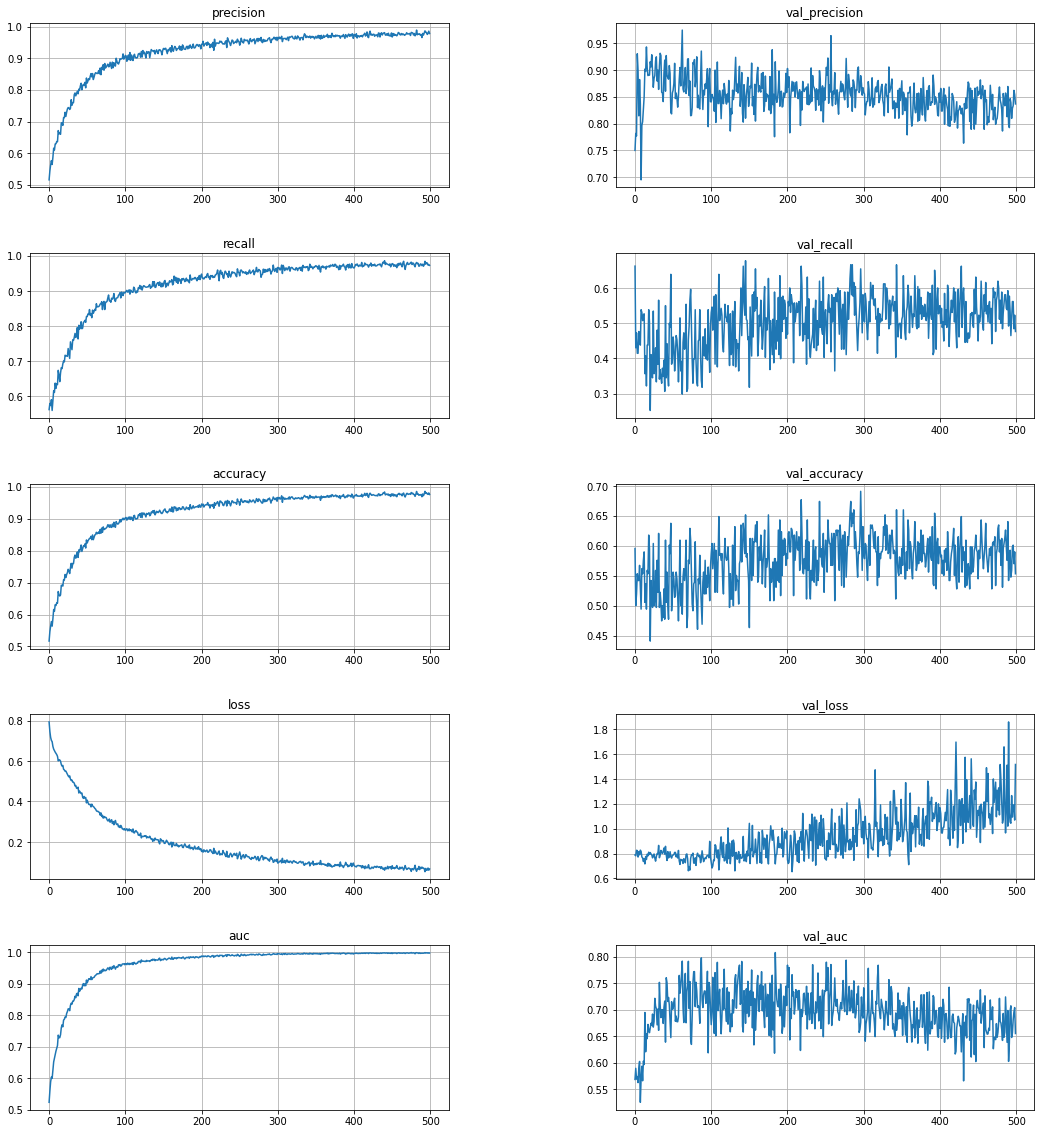

In [17]:
history_dict = history.history
history_dict.keys()

plotted_metrics = ['precision', 'recall', 'accuracy', 'loss', 'auc']

fig = plt.figure(figsize=(18, 4 * len(plotted_metrics)))
fig.subplots_adjust(hspace=0.4, wspace=0.4)


for idx, metric in enumerate(plotted_metrics):
    ax = plt.subplot(len(plotted_metrics), 2, 2*idx+1)
    plt.title(metric)
    plt.plot(history_dict[metric])
    ax.grid()
    
    ax = plt.subplot(len(plotted_metrics), 2, 2*idx+2)
    plt.title('val_{}'.format(metric))
    plt.plot(history_dict['val_{}'.format(metric)])
    ax.grid()

plt.show()

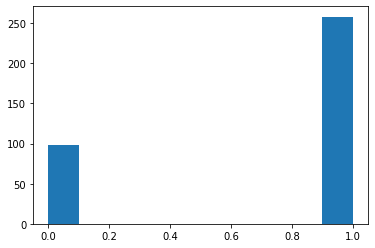

1.0    258
0.0     98
dtype: int64

In [13]:
plt.hist(Y_test)
plt.show()

pd.Series(Y_test).value_counts()

**FEATURE VISUALIZATION** Now, as the model is ready, lets try to explain it a little.

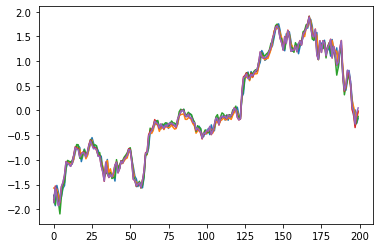

In [14]:
def plot_sample(sample):
    for idx, label in enumerate(['Open', 'High', 'Low', 'Close', 'Adj Close']):
        plt.plot(sample[:, idx])

plot_sample(X_test[2])

In [15]:
from keras.models import Model

model_viz = Model(inputs=model.inputs, outputs=model.layers[0].output)
model_viz.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1_input (InputLayer)  (None, 200, 5)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 200, 16)           416       
Total params: 416
Trainable params: 416
Non-trainable params: 0
_________________________________________________________________


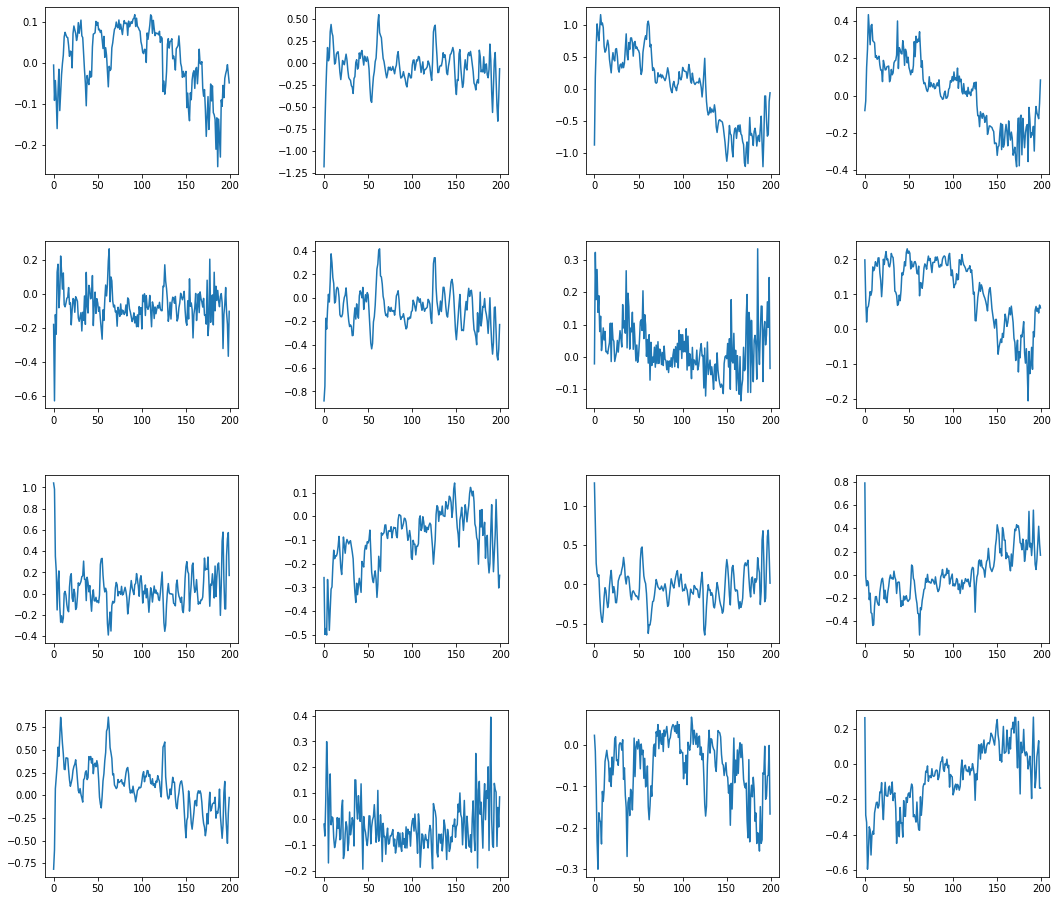

In [16]:
prediction = model_viz.predict(np.array([X_test[0]]))

square = 4
idx = 1

fig = plt.figure(figsize=(18, 16))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
    
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, idx)
        plt.plot(prediction[:,:,idx-1][0])
        idx += 1

plt.show()